In [3]:
!mkdir ../bdd100k/labels/valids/
!mkdir ../bdd100k/labels/trains/

### Format BDD100k Dataset to COCO format and then convert it to YOLO format ###

In [8]:
import os
import json
import argparse
from tqdm import tqdm



def bdd2coco_detection(id_dict, labeled_images, fn):

    images = list()
    annotations = list()

    counter = 0
    for i in tqdm(labeled_images):
        counter += 1
        image = dict()
        image['file_name'] = i['name']
        image['height'] = 720
        image['width'] = 1280

        image['id'] = counter

        empty_image = True

        for label in i['labels']:
            annotation = dict()
            category=label['category']
            if (category == "traffic light"):
                color = label['attributes']['trafficLightColor']
                category = "tl_" + color
            if category in id_dict.keys():
                empty_image = False
                annotation["iscrowd"] = 0
                annotation["image_id"] = image['id']
                x1 = label['box2d']['x1']
                y1 = label['box2d']['y1']
                x2 = label['box2d']['x2']
                y2 = label['box2d']['y2']
                annotation['bbox'] = [x1, y1, x2-x1, y2-y1]
                annotation['area'] = float((x2 - x1) * (y2 - y1))
                annotation['category_id'] = id_dict[category]
                annotation['ignore'] = 0
                annotation['id'] = label['id']
                annotation['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                annotations.append(annotation)

        if empty_image:
            continue

        images.append(image)

    attr_dict["images"] = images
    attr_dict["annotations"] = annotations
    attr_dict["type"] = "instances"

    print('saving...')
    json_string = json.dumps(attr_dict)
    with open(fn, "w") as file:
        file.write(json_string)


if __name__ == '__main__':

    label_dir="../bdd100k/labels/"
    save_path="../bdd100k/labels/"

    attr_dict = dict()
    attr_dict["categories"] = [
        {"supercategory": "none", "id": 1, "name": "person"},
        {"supercategory": "none", "id": 2, "name": "rider"},
        {"supercategory": "none", "id": 3, "name": "car"},
        {"supercategory": "none", "id": 4, "name": "bus"},
        {"supercategory": "none", "id": 5, "name": "truck"},
        {"supercategory": "none", "id": 6, "name": "bike"},
        {"supercategory": "none", "id": 7, "name": "motor"},
        {"supercategory": "none", "id": 8, "name": "tl_green"},
        {"supercategory": "none", "id": 9, "name": "tl_red"},
        {"supercategory": "none", "id": 10, "name": "tl_yellow"},
        {"supercategory": "none", "id": 11, "name": "tl_none"},
        {"supercategory": "none", "id": 12, "name": "traffic sign"},
        {"supercategory": "none", "id": 13, "name": "train"}
    ]

    attr_id_dict = {i['name']: i['id'] for i in attr_dict['categories']}

    # create BDD training set detections in COCO format
    print('Loading training set...')
    with open(os.path.join(label_dir, 'bdd100k_labels_images_train.json')) as f:
        train_labels = json.load(f)
    print('Converting training set...')

    out_fn = os.path.join(save_path, 'bdd100k_labels_images_det_coco_train.json')
    bdd2coco_detection(attr_id_dict, train_labels, out_fn)

    print('Loading validation set...')
    # create BDD validation set detections in COCO format
    with open(os.path.join(label_dir, 'bdd100k_labels_images_val.json')) as f:
        val_labels = json.load(f)
    print('Converting validation set...')

    out_fn = os.path.join(save_path, 'bdd100k_labels_images_det_coco_val.json')
    bdd2coco_detection(attr_id_dict, val_labels, out_fn)

Loading training set...
Converting training set...


100%|██████████| 69863/69863 [00:03<00:00, 19271.96it/s]


saving...
Loading validation set...
Converting validation set...


100%|██████████| 10000/10000 [00:00<00:00, 55310.55it/s]

saving...


In [9]:
import sys
import os
from PIL import Image

import json

# Common Data format
"""
{
    "filename" :      
                {                  
                    "size" :
                                {
                                    "width" : <string>
                                    "height" : <string>
                                    "depth" : <string>
                                }
                
                    "objects" :
                                {
                                    "num_obj" : <int>
                                    "<index>" :
                                                {
                                                    "name" : <string>
                                                    "bndbox" :
                                                                {
                                                                    "xmin" : <float>
                                                                    "ymin" : <float>
                                                                    "xmax" : <float>
                                                                    "ymax" : <float>
                                                                }
                                                }
                                    ...
                
                
                                }
                }
"""

# XML Data format
"""
{
    "filename" : <XML Object>
    ...
}
"""

def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s|%s| %s%% (%s/%s)  %s' % (prefix, bar, percent, iteration, total, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total:
        print("\n")

class COCO:
    """
    Handler Class for COCO Format
    """

    @staticmethod
    def parse(json_path):

        try:
            json_data = json.load(open(json_path))

            images_info = json_data["images"]
            cls_info = json_data["categories"]

            data = {}

            progress_length = len(json_data["annotations"])
            progress_cnt = 0
            printProgressBar(0, progress_length, prefix='\nCOCO Parsing:'.ljust(15), suffix='Complete', length=40)

            for anno in json_data["annotations"]:

                image_id = anno["image_id"]
                cls_id = anno["category_id"]

                filename = None
                img_width = None
                img_height = None
                cls = None

                for info in images_info:
                        if info["id"] == image_id:
                            filename, img_width, img_height = \
                                info["file_name"].split(".")[0], info["width"], info["height"]

                for category in cls_info:
                    if category["id"] == cls_id:
                        cls = category["name"]

                size = {
                    "width": img_width,
                    "height": img_height,
                    "depth": "3"
                }

                bndbox = {
                    "xmin": anno["bbox"][0],
                    "ymin": anno["bbox"][1],
                    "xmax": anno["bbox"][2] + anno["bbox"][0],
                    "ymax": anno["bbox"][3] + anno["bbox"][1]
                }

                obj_info = {
                    "name": cls,
                    "bndbox": bndbox
                }

                if filename in data:
                    obj_idx = str(int(data[filename]["objects"]["num_obj"]))
                    data[filename]["objects"][str(obj_idx)] = obj_info
                    data[filename]["objects"]["num_obj"] = int(obj_idx) + 1

                elif filename not in data:

                    obj = {
                        "num_obj": "1",
                        "0": obj_info
                    }

                    data[filename] = {
                        "size": size,
                        "objects": obj
                    }

                printProgressBar(progress_cnt + 1, progress_length, prefix='COCO Parsing:'.ljust(15), suffix='Complete', length=40)
                progress_cnt += 1

            #print(json.dumps(data, indent=4, sort_keys = True))
            return True, data

        except Exception as e:

            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]

            msg = "ERROR : {}, moreInfo : {}\t{}\t{}".format(e, exc_type, fname, exc_tb.tb_lineno)

            return False, msg

class YOLO:
    """
    Handler Class for UDACITY Format
    """

    def __init__(self, cls_list_path):
        with open(cls_list_path, 'r') as file:
            l = file.read().splitlines()

        self.cls_list = l


    def coordinateCvt2YOLO(self,size, box):
        dw = 1. / size[0]
        dh = 1. / size[1]

        # (xmin + xmax / 2)
        x = (box[0] + box[1]) / 2.0
        # (ymin + ymax / 2)
        y = (box[2] + box[3]) / 2.0

        # (xmax - xmin) = w
        w = box[1] - box[0]
        # (ymax - ymin) = h
        h = box[3] - box[2]

        x = x * dw
        w = w * dw
        y = y * dh
        h = h * dh
        return (round(x,3), round(y,3), round(w,3), round(h,3))

    def parse(self, label_path, img_path, img_type=".png"):
        try:

            (dir_path, dir_names, filenames) = next(os.walk(os.path.abspath(label_path)))

            data = {}

            progress_length = len(filenames)
            progress_cnt = 0
            printProgressBar(0, progress_length, prefix='\nYOLO Parsing:'.ljust(15), suffix='Complete', length=40)

            for filename in filenames:

                txt = open(os.path.join(dir_path, filename), "r")

                filename = filename.split(".")[0]

                img = Image.open(os.path.join(img_path, "".join([filename, img_type])))
                img_width = str(img.size[0])
                img_height = str(img.size[1])
                img_depth = 3

                size = {
                    "width": img_width,
                    "height": img_height,
                    "depth": img_depth
                }

                obj = {}
                obj_cnt = 0

                for line in txt:
                    elements = line.split(" ")
                    name_id = elements[0]

                    xminAddxmax = float(elements[1]) * (2.0 * float(img_width))
                    yminAddymax = float(elements[2]) * (2.0 * float(img_height))

                    w = float(elements[3]) * float(img_width)
                    h = float(elements[4]) * float(img_height)

                    xmin = (xminAddxmax - w) / 2
                    ymin = (yminAddymax - h) / 2
                    xmax = xmin + w
                    ymax = ymin + h

                    bndbox = {
                        "xmin": float(xmin),
                        "ymin": float(ymin),
                        "xmax": float(xmax),
                        "ymax": float(ymax)
                    }


                    obj_info = {
                        "name": name_id,
                        "bndbox": bndbox
                    }

                    obj[str(obj_cnt)] =obj_info
                    obj_cnt += 1

                obj["num_obj"] =  obj_cnt

                data[filename] = {
                    "size": size,
                    "objects": obj
                }

                printProgressBar(progress_cnt + 1, progress_length, prefix='YOLO Parsing:'.ljust(15), suffix='Complete',
                                 length=40)
                progress_cnt += 1

            return True, data

        except Exception as e:

            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]

            msg = "ERROR : {}, moreInfo : {}\t{}\t{}".format(e, exc_type, fname, exc_tb.tb_lineno)

            return False, msg

    def generate(self, data):

        try:

            progress_length =len(data)
            progress_cnt = 0
            printProgressBar(0, progress_length, prefix='\nYOLO Generating:'.ljust(15), suffix='Complete', length=40)

            result = {}

            for key in data:
                img_width = int(data[key]["size"]["width"])
                img_height = int(data[key]["size"]["height"])

                contents = ""

                for idx in range(0, int(data[key]["objects"]["num_obj"])):

                    xmin = data[key]["objects"][str(idx)]["bndbox"]["xmin"]
                    ymin = data[key]["objects"][str(idx)]["bndbox"]["ymin"]
                    xmax = data[key]["objects"][str(idx)]["bndbox"]["xmax"]
                    ymax = data[key]["objects"][str(idx)]["bndbox"]["ymax"]

                    b = (float(xmin), float(xmax), float(ymin), float(ymax))
                    bb = self.coordinateCvt2YOLO((img_width, img_height), b)

                    cls_id = self.cls_list.index(data[key]["objects"][str(idx)]["name"])

                    bndbox = "".join(["".join([str(e), " "]) for e in bb])
                    contents = "".join([contents, str(cls_id), " ", bndbox[:-1], "\n"])

                result[key] = contents

                printProgressBar(progress_cnt + 1, progress_length, prefix='YOLO Generating:'.ljust(15),
                                 suffix='Complete',
                                 length=40)
                progress_cnt += 1

            return True, result

        except Exception as e:

            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]

            msg = "ERROR : {}, moreInfo : {}\t{}\t{}".format(e, exc_type, fname, exc_tb.tb_lineno)

            return False, msg

    def save(self, data, save_path, img_path, img_type, manipast_path):

        try:

            progress_length = len(data)
            progress_cnt = 0
            printProgressBar(0, progress_length, prefix='\nYOLO Saving:'.ljust(15), suffix='Complete', length=40)

            with open(os.path.abspath(os.path.join(manipast_path, "manifast.txt")), "w") as manipast_file:

                for key in data:
                    manipast_file.write(os.path.abspath(os.path.join(img_path, "".join([key, img_type, "\n"]))))

                    with open(os.path.abspath(os.path.join(save_path, "".join([key, ".txt"]))), "w") as output_txt_file:
                        output_txt_file.write(data[key])


                    printProgressBar(progress_cnt + 1, progress_length, prefix='YOLO Saving:'.ljust(15),
                                     suffix='Complete',
                                     length=40)
                    progress_cnt += 1

            return True, None

        except Exception as e:

            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]

            msg = "ERROR : {}, moreInfo : {}\t{}\t{}".format(e, exc_type, fname, exc_tb.tb_lineno)

            return False, msg


In [13]:

import os

def main(config):

    if config["datasets"] == "COCO":
        coco = COCO()
        yolo = YOLO(os.path.abspath(config["cls_list"]))

        flag, data = coco.parse(config["label"])

        if flag == True:
            flag, data = yolo.generate(data)

            if flag == True:
                flag, data = yolo.save(data, config["output_path"], config["img_path"],
                                        config["img_type"], config["manipast_path"])

                if flag == False:
                    print("Saving Result : {}, msg : {}".format(flag, data))

            else:
                print("YOLO Generating Result : {}, msg : {}".format(flag, data))

        else:
            print("COCO Parsing Result : {}, msg : {}".format(flag, data))

    else:
        print("Unkwon Datasets")

if __name__ == '__main__':

    config ={
        "datasets": "COCO",
        "img_path": "../bdd100k/images/100k/train",
        "label": "../bdd100k/labels/bdd100k_labels_images_det_coco_train.json",
        "img_type": ".jpg",
        "manipast_path": "./",
        "output_path": "../bdd100k/labels/trains/",
        "cls_list": "bdd100k.names",
    }
    # config ={
    #     "datasets": "COCO",
    #     "img_path": "../bdd100k/images/100k/val",
    #     "label": "../bdd100k/labels/bdd100k_labels_images_det_coco_val.json",
    #     "img_type": ".jpg",
    #     "manipast_path": "./",
    #     "output_path": "../bdd100k/labels/valids/",
    #     "cls_list": "bdd100k.names",
    # }

    main(config)


COCO Parsing:  |████████████████████████████████████████| 100.0% (1286871/1286871)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (69863/69863)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (69863/69863)  Complete



### GLOBAL VARS

In [8]:
IMAGE_ROOT_DIR = "../bdd100k/images/100k/"
LABEL_ROOT_DIR = "../bdd100k/labels/100k/"

TRAIN_IMAGE_DIR = IMAGE_ROOT_DIR + "train/"
VAL_IMAGE_DIR = IMAGE_ROOT_DIR + "val/"
TEST_IMAGE_DIR = IMAGE_ROOT_DIR + "test/"

TRAIN_LABEL_DIR = LABEL_ROOT_DIR + "train/"
VAL_LABEL_DIR = LABEL_ROOT_DIR + "val/"

### Check the Dataset

In [10]:
import glob, os,shutil

labels_list=glob.glob(f"{TRAIN_LABEL_DIR}"+"/"+"*.txt")
images_list=glob.glob(f"{TRAIN_IMAGE_DIR}"+"/"+"*.jpg")
print(len(labels_list))
print(len(images_list))

labels_list2=glob.glob(f"{VAL_LABEL_DIR}"+"/"+"*.txt")
images_list2=glob.glob(f"{VAL_IMAGE_DIR}"+"/"+"*.jpg")
print(len(labels_list2))
print(len(images_list2))

69863
70000
10000
10000


In [11]:
import cv2
import matplotlib.pyplot as plt 

img = cv2.imread(f"{VAL_IMAGE_DIR}/b1d4b62c-89eeb5d3.jpg")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


with open(f"{VAL_LABEL_DIR}/b1d4b62c-89eeb5d3.txt", "rt") as f:
    data_lines = f.readlines()

bboxes=[]
w=1280
h=720
for item in range(len(data_lines)):
    cl=int(data_lines[item].split(" ")[0])
    a=float(data_lines[item].split(" ")[1])
    b=float(data_lines[item].split(" ")[2])
    c=float(data_lines[item].split(" ")[3])
    d=float(data_lines[item].split(" ")[4][:-1])
    
    x1 = int((a-c/2)*w)
    y1 = int((b-d/2)*h)
    x2 = int((a+c/2)*w)
    y2 = int((b+d/2)*h)
    
    bboxes.append([x1,y1,x2,y2,cl])
    
print(bboxes)


[[952, 227, 1000, 242, 11], [67, 242, 90, 281, 7], [960, 257, 977, 301, 7], [1185, 324, 1223, 355, 7], [1171, 233, 1204, 284, 8], [565, 388, 678, 485, 2], [752, 410, 845, 482, 2], [716, 414, 757, 478, 2], [695, 432, 717, 479, 2], [682, 443, 696, 474, 2], [424, 437, 501, 475, 2], [517, 441, 563, 471, 2]]


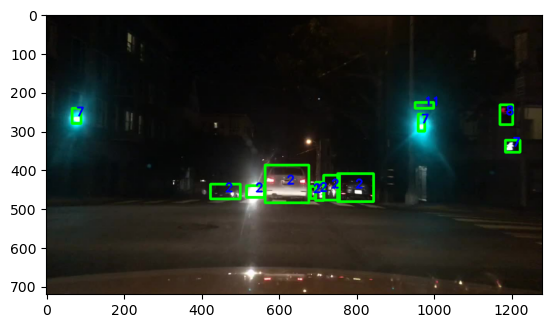

In [12]:
for c in bboxes:
    cv2.rectangle(img, (c[0],c[1]), (c[2], c[3]), (0, 255, 0), 5)
    cv2.putText(img, str(c[4]), (int((c[0]+c[2])/2), int((c[1]+c[3])/2)), 0, 1, (0, 0, 255),3)
    
plt.imshow(img)
plt.show()

In [13]:
%cat uc_data.yaml

train: ../bdd100k/images/100k/train
val: ../bdd100k/images/100k/val
test: ../bdd100k/images/100k/test

nc: 13
names: ['person','rider','car','bus','truck','bike','motor','tl_green','tl_red','tl_yellow','tl_none','t_sign','train']


## Downloading pre-trainded weights

In [14]:
# This file contains google utils: https://cloud.google.com/storage/docs/reference/libraries
# pip install --upgrade google-cloud-storage
# from google.cloud import storage

import os
import time
from pathlib import Path


def attempt_download(weights):
    # Attempt to download pretrained weights if not found locally
    weights = weights.strip()
    msg = weights + ' missing, try downloading from https://drive.google.com/drive/folders/1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J'

    r = 1
    if len(weights) > 0 and not os.path.isfile(weights):
        d = {'yolov3-spp.pt': '1mM67oNw4fZoIOL1c8M3hHmj66d8e-ni_',  # yolov3-spp.yaml
             'yolov5s.pt': '1R5T6rIyy3lLwgFXNms8whc-387H0tMQO',  # yolov5s.yaml
             'yolov5m.pt': '1vobuEExpWQVpXExsJ2w-Mbf3HJjWkQJr',  # yolov5m.yaml
             'yolov5l.pt': '1hrlqD1Wdei7UT4OgT785BEk1JwnSvNEV',  # yolov5l.yaml
             'yolov5x.pt': '1mM8aZJlWTxOg7BZJvNUMrTnA2AbeCVzS',  # yolov5x.yaml
             }

        file = Path(weights).name
        if file in d:
            r = gdrive_download(id=d[file], name=weights)

        if not (r == 0 and os.path.exists(weights) and os.path.getsize(weights) > 1E6):  # weights exist and > 1MB
            os.remove(weights) if os.path.exists(weights) else None  # remove partial downloads
            s = "curl -L -o %s 'https://storage.googleapis.com/ultralytics/yolov5/ckpt/%s'" % (weights, file)
            r = os.system(s)  # execute, capture return values

            # Error check
            if not (r == 0 and os.path.exists(weights) and os.path.getsize(weights) > 1E6):  # weights exist and > 1MB
                os.remove(weights) if os.path.exists(weights) else None  # remove partial downloads
                raise Exception(msg)


def gdrive_download(id='1HaXkef9z6y5l4vUnCYgdmEAj61c6bfWO', name='coco.zip'):
    # https://gist.github.com/tanaikech/f0f2d122e05bf5f971611258c22c110f
    # Downloads a file from Google Drive, accepting presented query
    # from utils.google_utils import *; gdrive_download()
    t = time.time()

    print('Downloading https://drive.google.com/uc?export=download&id=%s as %s... ' % (id, name), end='')
    os.remove(name) if os.path.exists(name) else None  # remove existing
    os.remove('cookie') if os.path.exists('cookie') else None

    # Attempt file download
    os.system("curl -c ./cookie -s -L \"https://drive.google.com/uc?export=download&id=%s\" > /dev/null" % id)
    if os.path.exists('cookie'):  # large file
        s = "curl -Lb ./cookie \"https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=%s\" -o %s" % (
            id, name)
    else:  # small file
        s = "curl -s -L -o %s 'https://drive.google.com/uc?export=download&id=%s'" % (name, id)
    r = os.system(s)  # execute, capture return values
    os.remove('cookie') if os.path.exists('cookie') else None

    # Error check
    if r != 0:
        os.remove(name) if os.path.exists(name) else None  # remove partial
        print('Download error ')  # raise Exception('Download error')
        return r

    # Unzip if archive
    if name.endswith('.zip'):
        print('unzipping... ', end='')
        os.system('unzip -q %s' % name)  # unzip
        os.remove(name)  # remove zip to free space

    print('Done (%.1fs)' % (time.time() - t))
    return r


In [17]:
attempt_download('weights/yolov5s.pt')
# attempt_download('weights/yolov5m.pt')
# attempt_download('weights/yolov5l.pt')
# attempt_download('weights/yolov5x.pt')

## Import Libraries

In [1]:
import torch.distributed as dist
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

mixed_precision = True
try:  # Mixed precision training https://github.com/NVIDIA/apex
    from apex import amp
except:
    print('Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex')
    mixed_precision = False  # not installed

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex


In [2]:
import test  # import test.py to get mAP after each epoch
from models.yolo import Model
from utils import google_utils
from utils.datasets import *
from utils.utils import *
import traceback

In [3]:
# Hyperparameters
hyp = {'optimizer': 'SGD',  # ['adam', 'SGD', None] if none, default is SGD
       'lr0': 0.01,  # initial learning rate (SGD=1E-2, Adam=1E-3)
       'momentum': 0.937,  # SGD momentum/Adam beta1
       'weight_decay': 5e-4,  # optimizer weight decay
       'giou': 0.05,  # giou loss gain
       'cls': 0.58,  # cls loss gain
       'cls_pw': 1.0,  # cls BCELoss positive_weight
       'obj': 1.0,  # obj loss gain (*=img_size/320 if img_size != 320)
       'obj_pw': 1.0,  # obj BCELoss positive_weight
       'iou_t': 0.20,  # iou training threshold
       'anchor_t': 4.0,  # anchor-multiple threshold
       'fl_gamma': 0.0,  # focal loss gamma (efficientDet default is gamma=1.5)
       'hsv_h': 0.014,  # image HSV-Hue augmentation (fraction)
       'hsv_s': 0.68,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.36,  # image HSV-Value augmentation (fraction)
       'degrees': 0.0,  # image rotation (+/- deg)
       'translate': 0.0,  # image translation (+/- fraction)
       'scale': 0.5,  # image scale (+/- gain)
       'shear': 0.0}  # image shear (+/- deg)


def train(hyp):
    print(f'Hyperparameters {hyp}')
    log_dir = tb_writer.log_dir if tb_writer else 'runs/evolution'  # run directory
    wdir = str(Path(log_dir) / 'weights') + os.sep  # weights directory

    os.makedirs(wdir, exist_ok=True)
    last = wdir + 'last.pt'
    best = wdir + 'best.pt'
    results_file = log_dir + os.sep + 'results.txt'

    # Save run settings
    with open(Path(log_dir) / 'hyp.yaml', 'w') as f:
        yaml.dump(hyp, f, sort_keys=False)
    with open(Path(log_dir) / 'opt.yaml', 'w') as f:
        yaml.dump(vars(opt), f, sort_keys=False)

    epochs = opt.epochs  # 300
    batch_size = opt.batch_size  # 64
    weights = opt.weights  # initial training weights

    # Configure
    init_seeds(1)
    with open(opt.data) as f:
        data_dict = yaml.load(f, Loader=yaml.FullLoader)  # model dict
    train_path = data_dict['train']
    test_path = data_dict['val']
    nc, names = (1, ['item']) if opt.single_cls else (int(data_dict['nc']), data_dict['names'])  # number classes, names
    assert len(names) == nc, '%g names found for nc=%g dataset in %s' % (len(names), nc, opt.data)  # check

    # Remove previous results
    for f in glob.glob('*_batch*.jpg') + glob.glob(results_file):
        os.remove(f)

    # Create model
    model = Model(opt.cfg, nc=nc).to(device)

    # Image sizes
    gs = int(max(model.stride))  # grid size (max stride)
    imgsz, imgsz_test = [check_img_size(x, gs) for x in opt.img_size]  # verify imgsz are gs-multiples

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in model.named_parameters():
        if v.requires_grad:
            if '.bias' in k:
                pg2.append(v)  # biases
            elif '.weight' in k and '.bn' not in k:
                pg1.append(v)  # apply weight decay
            else:
                pg0.append(v)  # all else

    if hyp['optimizer'] == 'adam':  # https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html#OneCycleLR
        optimizer = optim.Adam(pg0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))  # adjust beta1 to momentum
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    print('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.9 + 0.1  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    # plot_lr_scheduler(optimizer, scheduler, epochs, save_dir=log_dir)

    # Load Model
    google_utils.attempt_download(weights)
    start_epoch, best_fitness = 0, 0.0
    if weights.endswith('.pt'):  # pytorch format
        ckpt = torch.load(weights, map_location=device)  # load checkpoint

        # load model
        try:
            ckpt['model'] = {k: v for k, v in ckpt['model'].float().state_dict().items()
                             if model.state_dict()[k].shape == v.shape}  # to FP32, filter
            model.load_state_dict(ckpt['model'], strict=False)
        except KeyError as e:
            s = "%s is not compatible with %s. This may be due to model differences or %s may be out of date. " \
                "Please delete or update %s and try again, or use --weights '' to train from scratch." \
                % (opt.weights, opt.cfg, opt.weights, opt.weights)
            raise KeyError(s) from e

        # load optimizer
        if ckpt['optimizer'] is not None:
            optimizer.load_state_dict(ckpt['optimizer'])
            best_fitness = ckpt['best_fitness']

        # load results
        if ckpt.get('training_results') is not None:
            with open(results_file, 'w') as file:
                file.write(ckpt['training_results'])  # write results.txt

        # epochs
        start_epoch = ckpt['epoch'] + 1
        if epochs < start_epoch:
            print('%s has been trained for %g epochs. Fine-tuning for %g additional epochs.' %
                  (opt.weights, ckpt['epoch'], epochs))
            epochs += ckpt['epoch']  # finetune additional epochs

        del ckpt

    # Mixed precision training https://github.com/NVIDIA/apex
    if mixed_precision:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # Distributed training
    if device.type != 'cpu' and torch.cuda.device_count() > 1 and torch.distributed.is_available():
        dist.init_process_group(backend='nccl',  # distributed backend
                                init_method='tcp://127.0.0.1:9999',  # init method
                                world_size=1,  # number of nodes
                                rank=0)  # node rank
        model = torch.nn.parallel.DistributedDataParallel(model)
        # pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

    # Trainloader
    dataloader, dataset = create_dataloader(train_path, imgsz, batch_size, gs, opt,
                                            hyp=hyp, augment=True, cache=opt.cache_images, rect=opt.rect)
    mlc = np.concatenate(dataset.labels, 0)[:, 0].max()  # max label class
    nb = len(dataloader)  # number of batches
    assert mlc < nc, 'Label class %g exceeds nc=%g in %s. Correct your labels or your model.' % (mlc, nc, opt.cfg)

    # Testloader
    testloader = create_dataloader(test_path, imgsz_test, batch_size, gs, opt,
                                   hyp=hyp, augment=False, cache=opt.cache_images, rect=True)[0]

    # Model parameters
    hyp['cls'] *= nc / 80.  # scale coco-tuned hyp['cls'] to current dataset
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
    model.names = names

    # Class frequency
    labels = np.concatenate(dataset.labels, 0)
    c = torch.tensor(labels[:, 0])  # classes
    # cf = torch.bincount(c.long(), minlength=nc) + 1.
    # model._initialize_biases(cf.to(device))
    plot_labels(labels, save_dir=log_dir)
    if tb_writer:
        tb_writer.add_histogram('classes', c, 0)

    # Check anchors
    if not opt.noautoanchor:
        check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)

    # Exponential moving average
    ema = torch_utils.ModelEMA(model, updates=start_epoch * nb / accumulate)

    # Start training
    t0 = time.time()
    nw = max(3 * nb, 1e3)  # number of warmup iterations, max(3 epochs, 1k iterations)
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    scheduler.last_epoch = start_epoch - 1  # do not move
    print('Image sizes %g train, %g test' % (imgsz, imgsz_test))
    print('Using %g dataloader workers' % dataloader.num_workers)
    print('Starting training for %g epochs...' % epochs)
    # torch.autograd.set_detect_anomaly(True)
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        model.train()

        # Update image weights (optional)
        if dataset.image_weights:
            w = model.class_weights.cpu().numpy() * (1 - maps) ** 2  # class weights
            image_weights = labels_to_image_weights(dataset.labels, nc=nc, class_weights=w)
            dataset.indices = random.choices(range(dataset.n), weights=image_weights, k=dataset.n)  # rand weighted idx

        # Update mosaic border
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(4, device=device)  # mean losses
        print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0  # uint8 to float32, 0 - 255 to 0.0 - 1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss
            loss, loss_items = compute_loss(pred, targets.to(device), model)
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            # Backward
            if mixed_precision:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            # Optimize
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
            s = ('%10s' * 2 + '%10.4g' * 6) % (
                '%g/%g' % (epoch, epochs - 1), mem, *mloss, targets.shape[0], imgs.shape[-1])
            pbar.set_description(s)

            # Plot
            if ni < 3:
                f = str(Path(log_dir) / ('train_batch%g.jpg' % ni))  # filename
                result = plot_images(images=imgs, targets=targets, paths=paths, fname=f)
                if tb_writer and result is not None:
                    tb_writer.add_image(f, result, dataformats='HWC', global_step=epoch)
                    # tb_writer.add_graph(model, imgs)  # add model to tensorboard

            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        scheduler.step()

        # mAP
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs
        if not opt.notest or final_epoch:  # Calculate mAP
            results, maps, times = test.test(opt.data,
                                             batch_size=batch_size,
                                             imgsz=imgsz_test,
                                             save_json=final_epoch and opt.data.endswith(os.sep + 'coco.yaml'),
                                             model=ema.ema,
                                             single_cls=opt.single_cls,
                                             dataloader=testloader,
                                             save_dir=log_dir)

        # Write
        with open(results_file, 'a') as f:
            f.write(s + '%10.4g' * 7 % results + '\n')  # P, R, mAP, F1, test_losses=(GIoU, obj, cls)
        if len(opt.name) and opt.bucket:
            os.system('gsutil cp results.txt gs://%s/results/results%s.txt' % (opt.bucket, opt.name))

        # Tensorboard
        if tb_writer:
            tags = ['train/giou_loss', 'train/obj_loss', 'train/cls_loss',
                    'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/F1',
                    'val/giou_loss', 'val/obj_loss', 'val/cls_loss']
            for x, tag in zip(list(mloss[:-1]) + list(results), tags):
                tb_writer.add_scalar(tag, x, epoch)

        # Update best mAP
        fi = fitness(np.array(results).reshape(1, -1))  # fitness_i = weighted combination of [P, R, mAP, F1]
        if fi > best_fitness:
            best_fitness = fi

        # Save model
        save = (not opt.nosave) or (final_epoch and not opt.evolve)
        if save:
            with open(results_file, 'r') as f:  # create checkpoint
                ckpt = {'epoch': epoch,
                        'best_fitness': best_fitness,
                        'training_results': f.read(),
                        'model': ema.ema,
                        'optimizer': None if final_epoch else optimizer.state_dict()}

            # Save last, best and delete
            torch.save(ckpt, last)
            if (best_fitness == fi) and not final_epoch:
                torch.save(ckpt, best)
            del ckpt

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training

    # Strip optimizers
    n = ('_' if len(opt.name) and not opt.name.isnumeric() else '') + opt.name
    fresults, flast, fbest = 'results%s.txt' % n, wdir + 'last%s.pt' % n, wdir + 'best%s.pt' % n
    for f1, f2 in zip([wdir + 'last.pt', wdir + 'best.pt', 'results.txt'], [flast, fbest, fresults]):
        if os.path.exists(f1):
            os.rename(f1, f2)  # rename
            ispt = f2.endswith('.pt')  # is *.pt
            strip_optimizer(f2) if ispt else None  # strip optimizer
            os.system('gsutil cp %s gs://%s/weights' % (f2, opt.bucket)) if opt.bucket and ispt else None  # upload

    # Finish
    if not opt.evolve:
        plot_results(save_dir=log_dir)  # save as results.png
    print('%g epochs completed in %.3f hours.\n' % (epoch - start_epoch + 1, (time.time() - t0) / 3600))
    dist.destroy_process_group() if device.type != 'cpu' and torch.cuda.device_count() > 1 else None
    torch.cuda.empty_cache()
    return results



In [4]:
class Arguments():
    cfg = './models/custom_yolov5s.yaml'
    data= 'uc_data.yaml'
    hyp = ''
    epochs = 200
    batch_size=32
    img_size=[640, 640]
    rect = True
    resume = False
    nosave = False
    notest = False
    noautoanchor = True
    evolve = False
    bucket=''
    cache_images=True
    weights='weights/yolov5s.pt'
    name='yolov5s_bdd_pre_2'
    device = ''
    multi_scale=True
    single_cls = True
opt = Arguments()

Using CUDA device0 _CudaDeviceProperties(name='NVIDIA RTX A5000', total_memory=24245MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
Hyperparameters {'optimizer': 'SGD', 'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Overriding ./models/custom_yolov5s.yaml nc=13 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1 

/home/sci/zahid.aziz/miniconda3/envs/py-g-gpu/lib/python3.9/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sci/zahid.aziz/miniconda3/envs/py-g-gpu/lib/python3.9/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sci/zahid.aziz/miniconda3/envs/py-g-gpu/lib/python3.9/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'models.common.Focus' has changed. you can ret

Image sizes 640 train, 640 test
Using 8 dataloader workers
Starting training for 200 epochs...

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


  0%|          | 0/2188 [00:00<?, ?it/s]/home/sci/zahid.aziz/miniconda3/envs/py-g-gpu/lib/python3.9/site-packages/torch/cuda/memory.py:395: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(
     0/199     4.13G   0.06152   0.06071         0    0.1222       365       672: 100%|██████████| 2188/2188 [06:00<00:00,  6.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95:   0%|          | 0/313 [00:00<?, ?it/s]/home/sci/zahid.aziz/miniconda3/envs/py-g-gpu/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:42<00:00,  7.43it/s]

                 all       1e+04    1.86e+05       0.333       0.616       0.532       0.257

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     1/199     1.64G   0.05198   0.05789         0    0.1099       356       384: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:39<00:00,  7.85it/s]


                 all       1e+04    1.86e+05       0.319        0.63       0.543        0.27

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     2/199     4.39G   0.05074   0.05752         0    0.1083       332       800: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.81it/s]


                 all       1e+04    1.86e+05       0.356       0.631       0.557       0.278

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     3/199     1.64G   0.04957    0.0564         0     0.106       369       480: 100%|██████████| 2188/2188 [05:11<00:00,  7.02it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.74it/s]


                 all       1e+04    1.86e+05       0.391       0.638       0.573        0.29

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     4/199     16.8G   0.04855   0.05615         0    0.1047       360       384: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.70it/s]


                 all       1e+04    1.86e+05       0.367       0.661       0.589       0.301

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     5/199     1.56G   0.04793   0.05531         0    0.1032       365       448: 100%|██████████| 2188/2188 [05:03<00:00,  7.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.67it/s]


                 all       1e+04    1.86e+05       0.383       0.664       0.596       0.307

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     6/199     3.07G   0.04738   0.05423         0    0.1016       364       704: 100%|██████████| 2188/2188 [05:13<00:00,  6.98it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.67it/s]


                 all       1e+04    1.86e+05        0.38       0.674       0.606       0.315

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     7/199     6.39G   0.04719   0.05432         0    0.1015       355       608: 100%|██████████| 2188/2188 [05:26<00:00,  6.70it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:55<00:00,  5.62it/s]


                 all       1e+04    1.86e+05        0.38        0.68       0.612       0.319

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     8/199     13.5G   0.04691   0.05361         0    0.1005       366       384: 100%|██████████| 2188/2188 [05:27<00:00,  6.68it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:53<00:00,  5.88it/s]


                 all       1e+04    1.86e+05       0.379       0.686       0.616       0.322

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


     9/199     13.5G   0.04677   0.05356         0    0.1003       357       704: 100%|██████████| 2188/2188 [05:13<00:00,  6.99it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:52<00:00,  5.98it/s]


                 all       1e+04    1.86e+05       0.387       0.687        0.62       0.325

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    10/199     1.74G   0.04665   0.05352         0    0.1002       354       352: 100%|██████████| 2188/2188 [05:36<00:00,  6.50it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:45<00:00,  6.94it/s]


                 all       1e+04    1.86e+05       0.387       0.691       0.624       0.327

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    11/199       15G   0.04647   0.05307         0   0.09954       350       672: 100%|██████████| 2188/2188 [05:15<00:00,  6.94it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:53<00:00,  5.80it/s]


                 all       1e+04    1.86e+05       0.387       0.693       0.626       0.329

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    12/199     6.36G   0.04646   0.05314         0    0.0996       351       576: 100%|██████████| 2188/2188 [05:29<00:00,  6.64it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:51<00:00,  6.07it/s]


                 all       1e+04    1.86e+05       0.388       0.694       0.628        0.33

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    13/199     4.41G   0.04642    0.0537         0    0.1001       343       768: 100%|██████████| 2188/2188 [05:17<00:00,  6.89it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.389       0.696       0.629       0.331

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    14/199     14.6G   0.04639   0.05354         0   0.09993       341       576: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.389       0.697        0.63       0.332

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    15/199     14.6G   0.04624   0.05296         0    0.0992       347       768: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05        0.39       0.697        0.63       0.332

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    16/199     14.6G   0.04611   0.05289         0     0.099       350       768: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.391       0.697       0.631       0.333

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    17/199     14.6G   0.04622   0.05363         0   0.09986       353       352: 100%|██████████| 2188/2188 [05:04<00:00,  7.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.391       0.698       0.632       0.334

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    18/199     6.39G   0.04611   0.05327         0   0.09938       335       864: 100%|██████████| 2188/2188 [05:24<00:00,  6.73it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:51<00:00,  6.06it/s]


                 all       1e+04    1.86e+05       0.392       0.698       0.632       0.334

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    19/199     12.7G   0.04609   0.05303         0   0.09911       370       576: 100%|██████████| 2188/2188 [05:45<00:00,  6.32it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:50<00:00,  6.21it/s]


                 all       1e+04    1.86e+05       0.393       0.698       0.633       0.335

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    20/199     12.7G   0.04599   0.05293         0   0.09892       334       704: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


                 all       1e+04    1.86e+05       0.394       0.698       0.633       0.335

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    21/199      6.5G   0.04598   0.05276         0   0.09874       347       928: 100%|██████████| 2188/2188 [05:11<00:00,  7.02it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


                 all       1e+04    1.86e+05       0.396       0.697       0.633       0.335

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    22/199     13.5G     0.046   0.05312         0   0.09912       366       352: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


                 all       1e+04    1.86e+05       0.397       0.697       0.633       0.335

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    23/199     13.5G   0.04594   0.05339         0   0.09932       368       384: 100%|██████████| 2188/2188 [04:59<00:00,  7.30it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]


                 all       1e+04    1.86e+05       0.399       0.697       0.634       0.336

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    24/199     6.36G   0.04579   0.05252         0   0.09831       352       640: 100%|██████████| 2188/2188 [05:12<00:00,  7.00it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


                 all       1e+04    1.86e+05         0.4       0.697       0.634       0.336

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    25/199     12.7G   0.04569   0.05233         0   0.09802       357       640: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.65it/s]


                 all       1e+04    1.86e+05       0.401       0.697       0.634       0.336

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    26/199     12.7G   0.04571   0.05238         0   0.09809       364       928: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.402       0.697       0.635       0.336

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    27/199     12.7G   0.04573   0.05289         0   0.09862       352       864: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.64it/s]


                 all       1e+04    1.86e+05       0.403       0.697       0.635       0.337

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    28/199     1.66G   0.04567   0.05262         0   0.09829       353       416: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]


                 all       1e+04    1.86e+05       0.404       0.697       0.635       0.337

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    29/199     17.1G   0.04558   0.05244         0   0.09803       364       768: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]


                 all       1e+04    1.86e+05       0.405       0.698       0.636       0.337

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    30/199     17.1G   0.04559   0.05229         0   0.09788       350       448: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]


                 all       1e+04    1.86e+05       0.406       0.698       0.636       0.338

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    31/199      4.3G   0.04555   0.05179         0   0.09734       351       736: 100%|██████████| 2188/2188 [05:17<00:00,  6.90it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.406       0.698       0.637       0.338

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    32/199     15.9G   0.04562   0.05266         0   0.09829       349       704: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.63it/s]


                 all       1e+04    1.86e+05       0.407       0.698       0.637       0.338

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    33/199     15.9G    0.0455   0.05188         0   0.09738       350       928: 100%|██████████| 2188/2188 [05:12<00:00,  6.99it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:40<00:00,  7.65it/s]


                 all       1e+04    1.86e+05       0.407       0.698       0.637       0.338

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    34/199     15.9G   0.04549   0.05269         0   0.09817       370       576: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.407       0.698       0.637       0.338

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    35/199     15.9G   0.04549   0.05257         0   0.09805       353       928: 100%|██████████| 2188/2188 [05:06<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.409       0.698       0.637       0.339

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    36/199     6.56G   0.04551   0.05282         0   0.09833       362       896: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.409       0.698       0.638       0.339

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    37/199     12.7G   0.04547   0.05289         0   0.09836       356       608: 100%|██████████| 2188/2188 [05:02<00:00,  7.24it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05        0.41       0.698       0.638       0.339

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    38/199     12.7G   0.04538   0.05255         0   0.09793       342       576: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.411       0.699       0.639        0.34

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    39/199     12.7G   0.04535   0.05198         0   0.09733       360       640: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.412       0.699       0.639        0.34

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    40/199     1.62G   0.04532   0.05206         0   0.09738       369       512: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.412       0.699        0.64        0.34

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    41/199       18G   0.04531   0.05213         0   0.09745       358       864: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.413         0.7        0.64        0.34

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    42/199       18G    0.0453   0.05237         0   0.09767       370       480: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.413         0.7        0.64       0.341

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    43/199       18G   0.04535   0.05215         0   0.09749       349       608: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.413         0.7        0.64       0.341

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    44/199       18G   0.04518   0.05179         0   0.09697       362       736: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.60it/s]


                 all       1e+04    1.86e+05       0.414         0.7       0.641       0.341

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    45/199       18G    0.0452   0.05183         0   0.09703       344       704: 100%|██████████| 2188/2188 [05:07<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.414       0.701       0.641       0.342

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    46/199       18G   0.04527    0.0523         0   0.09758       352       800: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.62it/s]


                 all       1e+04    1.86e+05       0.414       0.701       0.642       0.342

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    47/199       18G   0.04517   0.05251         0   0.09768       355       736: 100%|██████████| 2188/2188 [05:00<00:00,  7.28it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.414       0.701       0.642       0.342

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    48/199       18G   0.04514   0.05193         0   0.09707       351       672: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.415       0.702       0.643       0.343

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    49/199       18G    0.0451   0.05212         0   0.09723       368       448: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.416       0.702       0.643       0.343

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    50/199     6.36G   0.04502   0.05198         0     0.097       370       544: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.60it/s]


                 all       1e+04    1.86e+05       0.416       0.703       0.644       0.343

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    51/199     13.2G   0.04502   0.05191         0   0.09693       366       640: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.416       0.703       0.644       0.343

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    52/199     13.2G   0.04504   0.05146         0    0.0965       368       608: 100%|██████████| 2188/2188 [05:11<00:00,  7.03it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.60it/s]


                 all       1e+04    1.86e+05       0.417       0.703       0.645       0.344

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    53/199     13.2G   0.04505   0.05213         0   0.09719       352       352: 100%|██████████| 2188/2188 [05:04<00:00,  7.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.60it/s]


                 all       1e+04    1.86e+05       0.416       0.704       0.645       0.344

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    54/199     6.39G   0.04499   0.05244         0   0.09743       358       832: 100%|██████████| 2188/2188 [05:00<00:00,  7.28it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.416       0.704       0.645       0.344

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    55/199     13.4G     0.045   0.05228         0   0.09729       354       864: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.416       0.705       0.646       0.345

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    56/199     13.4G     0.045   0.05187         0   0.09687       350       736: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.415       0.705       0.646       0.345

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    57/199     13.4G   0.04492   0.05168         0    0.0966       342       544: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.706       0.647       0.345

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    58/199     13.4G   0.04491   0.05173         0   0.09665       363       480: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.415       0.706       0.647       0.345

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    59/199     5.91G   0.04485   0.05146         0   0.09631       352       960: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.61it/s]


                 all       1e+04    1.86e+05       0.414       0.707       0.647       0.346

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    60/199     13.7G   0.04485   0.05181         0   0.09666       361       672: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.414       0.707       0.648       0.346

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    61/199     13.7G   0.04485   0.05201         0   0.09686       366       640: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.414       0.707       0.648       0.346

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    62/199     13.7G   0.04486   0.05212         0   0.09698       331       640: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.415       0.708       0.649       0.346

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    63/199     13.7G   0.04479    0.0517         0   0.09648       366       928: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.414       0.709       0.649       0.346

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    64/199     13.7G   0.04476   0.05202         0   0.09678       336       864: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.414       0.709       0.649       0.347

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    65/199     13.7G    0.0447   0.05151         0   0.09621       353       512: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.414       0.709       0.649       0.347

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    66/199     13.7G   0.04466   0.05114         0   0.09579       364       768: 100%|██████████| 2188/2188 [05:13<00:00,  6.99it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.415        0.71        0.65       0.347

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    67/199     13.7G   0.04472    0.0521         0   0.09682       327       960: 100%|██████████| 2188/2188 [05:01<00:00,  7.27it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415        0.71        0.65       0.347

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    68/199     1.58G   0.04456   0.05094         0    0.0955       365       320: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.415        0.71        0.65       0.348

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    69/199     15.8G    0.0446   0.05171         0   0.09632       329       928: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.711       0.651       0.348

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    70/199     15.8G   0.04464   0.05149         0   0.09613       361       448: 100%|██████████| 2188/2188 [05:06<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.711       0.651       0.348

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    71/199     15.8G   0.04456   0.05129         0   0.09584       366       864: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.415       0.711       0.651       0.348

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    72/199     15.8G   0.04448   0.05109         0   0.09557       348       672: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.414       0.711       0.651       0.349

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    73/199     15.8G   0.04452   0.05118         0    0.0957       370       832: 100%|██████████| 2188/2188 [05:07<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.414       0.712       0.652       0.349

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    74/199     15.8G   0.04454    0.0516         0   0.09614       347       384: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.414       0.712       0.652       0.349

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    75/199     15.8G    0.0445   0.05126         0   0.09576       362       832: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.414       0.713       0.652       0.349

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    76/199     15.8G   0.04444   0.05114         0   0.09558       334       672: 100%|██████████| 2188/2188 [05:12<00:00,  7.00it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.414       0.713       0.653       0.349

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    77/199     15.8G   0.04439   0.05114         0   0.09553       363       768: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.414       0.713       0.653        0.35

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    78/199     15.8G   0.04448   0.05162         0    0.0961       363       864: 100%|██████████| 2188/2188 [05:03<00:00,  7.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.414       0.713       0.653        0.35

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    79/199     15.8G   0.04434   0.05065         0     0.095       347       768: 100%|██████████| 2188/2188 [05:11<00:00,  7.03it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.714       0.654        0.35

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    80/199     15.8G   0.04432   0.05132         0   0.09564       367       512: 100%|██████████| 2188/2188 [05:03<00:00,  7.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.415       0.714       0.654       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    81/199     15.8G   0.04427   0.05112         0   0.09539       345       960: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.416       0.714       0.655       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    82/199     15.8G   0.04427   0.05122         0   0.09549       361       576: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.59it/s]


                 all       1e+04    1.86e+05       0.415       0.714       0.655       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    83/199     15.8G   0.04427   0.05114         0   0.09541       356       448: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.715       0.655       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    84/199     15.8G   0.04429   0.05158         0   0.09587       357       416: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.715       0.656       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    85/199     15.8G   0.04418   0.05067         0   0.09485       336       736: 100%|██████████| 2188/2188 [05:10<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.715       0.656       0.351

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    86/199     15.8G    0.0442   0.05124         0   0.09543       355       512: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.414       0.715       0.656       0.352

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    87/199     15.8G   0.04416   0.05114         0    0.0953       356       640: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.415       0.716       0.657       0.352

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    88/199     15.8G   0.04409   0.05052         0   0.09461       347       896: 100%|██████████| 2188/2188 [05:11<00:00,  7.02it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.415       0.716       0.657       0.352

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    89/199     15.8G   0.04405   0.05065         0    0.0947       347       864: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.716       0.657       0.352

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    90/199     15.8G   0.04413    0.0514         0   0.09554       341       320: 100%|██████████| 2188/2188 [05:01<00:00,  7.26it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.716       0.657       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    91/199     15.8G   0.04403   0.05091         0   0.09495       373       960: 100%|██████████| 2188/2188 [05:05<00:00,  7.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05       0.416       0.716       0.657       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    92/199     15.8G     0.044   0.05097         0   0.09497       332       544: 100%|██████████| 2188/2188 [05:04<00:00,  7.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.415       0.717       0.658       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    93/199     15.8G   0.04401   0.05101         0   0.09501       365       576: 100%|██████████| 2188/2188 [05:05<00:00,  7.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.415       0.717       0.658       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    94/199     15.8G   0.04393   0.05082         0   0.09475       355       352: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.415       0.718       0.658       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    95/199     15.8G    0.0439   0.05031         0   0.09421       368       768: 100%|██████████| 2188/2188 [05:09<00:00,  7.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.414       0.718       0.659       0.353

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    96/199     15.8G    0.0439   0.05046         0   0.09436       355       416: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.414       0.719       0.659       0.354

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    97/199     15.8G   0.04382   0.05036         0   0.09418       348       512: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.414       0.719        0.66       0.354

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    98/199     15.8G   0.04381   0.05068         0   0.09449       366       800: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.415       0.719        0.66       0.354

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    99/199     15.8G    0.0438   0.05053         0   0.09434       359       864: 100%|██████████| 2188/2188 [05:06<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.415        0.72        0.66       0.355

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   100/199     15.8G    0.0437    0.0504         0    0.0941       353       768: 100%|██████████| 2188/2188 [05:05<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.416        0.72       0.661       0.355

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   101/199     15.8G   0.04376   0.05017         0   0.09394       368       352: 100%|██████████| 2188/2188 [05:12<00:00,  6.99it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.417        0.72       0.661       0.355

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   102/199     15.8G   0.04375   0.05037         0   0.09412       368       640: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.417        0.72       0.661       0.355

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   103/199     15.8G   0.04373   0.05108         0    0.0948       361       736: 100%|██████████| 2188/2188 [04:59<00:00,  7.31it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.417        0.72       0.661       0.355

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   104/199     15.8G   0.04362   0.05004         0   0.09366       371       416: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.418        0.72       0.661       0.356

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   105/199     15.8G   0.04364   0.05043         0   0.09407       362       896: 100%|██████████| 2188/2188 [05:03<00:00,  7.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.418        0.72       0.662       0.356

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   106/199     15.8G   0.04351   0.04984         0   0.09334       354       736: 100%|██████████| 2188/2188 [05:09<00:00,  7.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.419        0.72       0.662       0.356

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   107/199     15.8G   0.04358   0.05056         0   0.09414       366       320: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05        0.42        0.72       0.662       0.356

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   108/199     15.8G   0.04356   0.05039         0   0.09395       341       544: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05        0.42       0.721       0.663       0.356

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   109/199     15.8G   0.04348    0.0498         0   0.09328       350       512: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.58it/s]


                 all       1e+04    1.86e+05        0.42       0.721       0.663       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   110/199     15.8G   0.04349   0.05007         0   0.09356       370       576: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05        0.42       0.721       0.663       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   111/199     15.8G   0.04347   0.04997         0   0.09344       366       416: 100%|██████████| 2188/2188 [05:10<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.419       0.721       0.663       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   112/199     15.8G   0.04337   0.04995         0   0.09332       358       352: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.419       0.722       0.663       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   113/199     15.8G    0.0434   0.04971         0   0.09311       359       768: 100%|██████████| 2188/2188 [05:10<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.419       0.722       0.663       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   114/199     15.8G   0.04337   0.05045         0   0.09382       367       736: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.419       0.722       0.664       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   115/199     15.8G   0.04329   0.04972         0   0.09301       361       544: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.419       0.723       0.664       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   116/199     15.8G   0.04328   0.04984         0   0.09312       364       576: 100%|██████████| 2188/2188 [05:05<00:00,  7.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.419       0.723       0.665       0.357

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   117/199     15.8G   0.04322    0.0501         0   0.09332       358       864: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.419       0.724       0.665       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   118/199     15.8G   0.04321   0.04989         0    0.0931       354       608: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.419       0.724       0.665       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   119/199     15.8G   0.04318   0.04952         0    0.0927       356       416: 100%|██████████| 2188/2188 [05:09<00:00,  7.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.419       0.724       0.665       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   120/199     15.8G   0.04316   0.04956         0   0.09271       358       928: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.418       0.725       0.666       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   121/199     15.8G   0.04309   0.04936         0   0.09245       357       800: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.418       0.725       0.666       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   122/199     15.8G   0.04309   0.04952         0   0.09261       357       512: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.418       0.726       0.666       0.358

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   123/199     15.8G   0.04305   0.04965         0    0.0927       363       736: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.48it/s]


                 all       1e+04    1.86e+05       0.419       0.726       0.667       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   124/199     15.8G     0.043   0.04958         0   0.09258       340       384: 100%|██████████| 2188/2188 [05:05<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05        0.42       0.726       0.667       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   125/199     15.8G   0.04303    0.0499         0   0.09293       360       576: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05        0.42       0.726       0.667       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   126/199     15.8G   0.04299   0.04964         0   0.09262       342       864: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05        0.42       0.727       0.668       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   127/199     15.8G   0.04288   0.04918         0   0.09205       361       768: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05        0.42       0.727       0.668       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   128/199     15.8G   0.04288   0.04945         0   0.09233       344       960: 100%|██████████| 2188/2188 [05:05<00:00,  7.16it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05        0.42       0.727       0.668       0.359

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   129/199     15.8G   0.04282   0.04983         0   0.09265       359       640: 100%|██████████| 2188/2188 [05:01<00:00,  7.26it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.421       0.727       0.668        0.36

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   130/199     15.8G   0.04283   0.04929         0   0.09213       353       416: 100%|██████████| 2188/2188 [05:05<00:00,  7.17it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.421       0.727       0.669        0.36

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   131/199     15.8G   0.04281   0.04886         0   0.09167       353       832: 100%|██████████| 2188/2188 [05:11<00:00,  7.02it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.421       0.727       0.669        0.36

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   132/199     15.8G   0.04272    0.0496         0   0.09232       355       768: 100%|██████████| 2188/2188 [05:03<00:00,  7.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.422       0.727       0.669        0.36

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   133/199     15.8G   0.04267    0.0488         0   0.09147       342       608: 100%|██████████| 2188/2188 [05:10<00:00,  7.04it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.422       0.728        0.67        0.36

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   134/199     15.8G   0.04274   0.04951         0   0.09225       368       928: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.423       0.728        0.67       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   135/199     15.8G   0.04264   0.04897         0   0.09162       350       832: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.57it/s]


                 all       1e+04    1.86e+05       0.423       0.728        0.67       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   136/199     15.8G   0.04257   0.04884         0   0.09141       369       512: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.423       0.728        0.67       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   137/199     15.8G   0.04259   0.04885         0   0.09145       358       960: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.423       0.728        0.67       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   138/199     15.8G   0.04254   0.04886         0   0.09139       359       864: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.423       0.728       0.671       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   139/199     15.8G   0.04255   0.04875         0   0.09129       340       384: 100%|██████████| 2188/2188 [05:10<00:00,  7.04it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.423       0.729       0.671       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   140/199     15.8G   0.04248   0.04906         0   0.09155       325       768: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.423       0.729       0.671       0.361

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   141/199     15.8G   0.04243   0.04853         0   0.09096       335       864: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.423       0.729       0.671       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   142/199     15.8G   0.04239   0.04873         0   0.09112       350       672: 100%|██████████| 2188/2188 [05:06<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.423       0.729       0.671       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   143/199     15.8G    0.0424   0.04889         0   0.09129       358       384: 100%|██████████| 2188/2188 [05:05<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.424       0.729       0.672       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   144/199     15.8G   0.04236   0.04874         0   0.09111       369       448: 100%|██████████| 2188/2188 [05:04<00:00,  7.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


                 all       1e+04    1.86e+05       0.424        0.73       0.672       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   145/199     15.8G   0.04233   0.04875         0   0.09108       352       672: 100%|██████████| 2188/2188 [05:05<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.424        0.73       0.672       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   146/199     15.8G   0.04227   0.04859         0   0.09086       336       544: 100%|██████████| 2188/2188 [05:06<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.425        0.73       0.672       0.362

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   147/199     15.8G   0.04226   0.04891         0   0.09117       343       384: 100%|██████████| 2188/2188 [05:03<00:00,  7.21it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.425        0.73       0.673       0.363

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   148/199     15.8G   0.04221   0.04876         0   0.09097       358       384: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.425        0.73       0.673       0.363

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   149/199     15.8G   0.04222   0.04912         0   0.09134       354       800: 100%|██████████| 2188/2188 [04:58<00:00,  7.32it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.425        0.73       0.673       0.363

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   150/199     15.8G   0.04219   0.04885         0   0.09104       338       736: 100%|██████████| 2188/2188 [05:02<00:00,  7.24it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.425       0.731       0.673       0.363

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   151/199     15.8G   0.04211   0.04774         0   0.08985       367       928: 100%|██████████| 2188/2188 [05:13<00:00,  6.99it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.425       0.731       0.673       0.363

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   152/199     15.8G   0.04209   0.04894         0   0.09104       365       768: 100%|██████████| 2188/2188 [05:00<00:00,  7.29it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.426       0.731       0.673       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   153/199     15.8G   0.04201   0.04801         0   0.09002       368       640: 100%|██████████| 2188/2188 [05:07<00:00,  7.13it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.426       0.731       0.674       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   154/199     15.8G   0.04201   0.04823         0   0.09024       354       352: 100%|██████████| 2188/2188 [05:04<00:00,  7.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.426       0.731       0.674       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   155/199     15.8G   0.04201   0.04804         0   0.09005       358       384: 100%|██████████| 2188/2188 [05:09<00:00,  7.07it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.426       0.731       0.674       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   156/199     15.8G   0.04193   0.04814         0   0.09007       364       512: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.427       0.731       0.674       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   157/199     15.8G   0.04185   0.04811         0   0.08996       349       896: 100%|██████████| 2188/2188 [05:04<00:00,  7.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


                 all       1e+04    1.86e+05       0.427       0.731       0.674       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   158/199     15.8G   0.04189   0.04785         0   0.08974       368       512: 100%|██████████| 2188/2188 [05:09<00:00,  7.06it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.427       0.732       0.675       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   159/199     15.8G   0.04187   0.04786         0   0.08972       348       576: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.428       0.732       0.675       0.364

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   160/199     15.8G   0.04179   0.04808         0   0.08987       356       896: 100%|██████████| 2188/2188 [05:03<00:00,  7.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.428       0.732       0.675       0.365

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   161/199     15.8G   0.04172   0.04766         0   0.08937       343       320: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.429       0.732       0.676       0.365

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   162/199     15.8G   0.04173   0.04781         0   0.08954       362       448: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05        0.43       0.732       0.676       0.365

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   163/199     15.8G   0.04163   0.04761         0   0.08924       318       544: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05        0.43       0.733       0.676       0.365

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   164/199     15.8G   0.04167   0.04786         0   0.08953       348       640: 100%|██████████| 2188/2188 [05:06<00:00,  7.14it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05        0.43       0.733       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   165/199     15.8G   0.04162   0.04801         0   0.08963       345       736: 100%|██████████| 2188/2188 [05:03<00:00,  7.22it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.56it/s]


                 all       1e+04    1.86e+05       0.431       0.733       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   166/199     15.8G   0.04156   0.04746         0   0.08902       364       576: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.431       0.733       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   167/199     15.8G   0.04156   0.04777         0   0.08933       365       832: 100%|██████████| 2188/2188 [05:02<00:00,  7.23it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.431       0.733       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   168/199     15.8G   0.04153   0.04727         0    0.0888       360       704: 100%|██████████| 2188/2188 [05:12<00:00,  7.00it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.431       0.733       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   169/199     15.8G   0.04151   0.04746         0   0.08896       364       672: 100%|██████████| 2188/2188 [05:09<00:00,  7.08it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.431       0.734       0.677       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   170/199     15.8G   0.04145     0.047         0   0.08845       361       704: 100%|██████████| 2188/2188 [05:10<00:00,  7.05it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.432       0.734       0.678       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   171/199     15.8G   0.04147   0.04778         0   0.08925       357       320: 100%|██████████| 2188/2188 [05:02<00:00,  7.24it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


                 all       1e+04    1.86e+05       0.432       0.734       0.678       0.366

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   172/199     15.8G   0.04143   0.04746         0   0.08889       342       320: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.432       0.734       0.678       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   173/199     15.8G   0.04136   0.04698         0   0.08834       336       704: 100%|██████████| 2188/2188 [05:11<00:00,  7.03it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.432       0.734       0.678       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   174/199     15.8G   0.04138   0.04722         0    0.0886       369       864: 100%|██████████| 2188/2188 [05:08<00:00,  7.10it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.432       0.734       0.678       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   175/199     15.8G   0.04135   0.04742         0   0.08877       355       864: 100%|██████████| 2188/2188 [05:04<00:00,  7.18it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.433       0.734       0.678       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   176/199     15.8G   0.04132   0.04702         0   0.08833       365       576: 100%|██████████| 2188/2188 [05:10<00:00,  7.04it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.433       0.734       0.678       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   177/199     15.8G   0.04124   0.04705         0   0.08829       347       384: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.433       0.734       0.679       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   178/199     15.8G   0.04125   0.04742         0   0.08867       357       384: 100%|██████████| 2188/2188 [05:01<00:00,  7.25it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.434       0.735       0.679       0.367

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   179/199     15.8G   0.04124   0.04703         0   0.08827       369       704: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.434       0.734       0.679       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   180/199     15.8G   0.04115    0.0471         0   0.08826       359       800: 100%|██████████| 2188/2188 [05:04<00:00,  7.19it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.434       0.734       0.679       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   181/199     15.8G    0.0412    0.0468         0   0.08801       324       480: 100%|██████████| 2188/2188 [05:07<00:00,  7.11it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.434       0.734       0.679       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   182/199     15.8G   0.04115   0.04692         0   0.08808       361       768: 100%|██████████| 2188/2188 [05:07<00:00,  7.12it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.55it/s]


                 all       1e+04    1.86e+05       0.435       0.735       0.679       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   183/199     15.8G    0.0412   0.04704         0   0.08824       324       480: 100%|██████████| 2188/2188 [05:06<00:00,  7.15it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.54it/s]


                 all       1e+04    1.86e+05       0.435       0.735       0.679       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   184/199     15.8G   0.04109   0.04663         0   0.08772       363       512: 100%|██████████| 2188/2188 [05:08<00:00,  7.09it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   185/199     15.8G   0.04107   0.04642         0   0.08749       348       384: 100%|██████████| 2188/2188 [05:15<00:00,  6.94it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:57<00:00,  5.40it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   186/199     15.8G   0.04108   0.04651         0   0.08759       368       928: 100%|██████████| 2188/2188 [05:37<00:00,  6.49it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:41<00:00,  7.53it/s]


                 all       1e+04    1.86e+05       0.436       0.735        0.68       0.368

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   187/199     15.8G   0.04108   0.04702         0   0.08811       354       512: 100%|██████████| 2188/2188 [05:30<00:00,  6.63it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:54<00:00,  5.78it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   188/199     15.8G   0.04103   0.04672         0   0.08776       365       736: 100%|██████████| 2188/2188 [05:46<00:00,  6.32it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   189/199     15.8G   0.04107     0.047         0   0.08807       368       352: 100%|██████████| 2188/2188 [05:47<00:00,  6.29it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:55<00:00,  5.66it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   190/199     15.8G   0.04104   0.04644         0   0.08748       365       672: 100%|██████████| 2188/2188 [05:52<00:00,  6.20it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:54<00:00,  5.70it/s]


                 all       1e+04    1.86e+05       0.435       0.735        0.68       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   191/199     15.8G   0.04097    0.0462         0   0.08717       357       416: 100%|██████████| 2188/2188 [05:28<00:00,  6.66it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:46<00:00,  6.68it/s]


                 all       1e+04    1.86e+05       0.436       0.736        0.68       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   192/199     15.8G   0.04101    0.0471         0   0.08811       364       928: 100%|██████████| 2188/2188 [05:42<00:00,  6.39it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:54<00:00,  5.78it/s]


                 all       1e+04    1.86e+05       0.436       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   193/199     15.8G   0.04101   0.04654         0   0.08755       345       640: 100%|██████████| 2188/2188 [05:36<00:00,  6.50it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:53<00:00,  5.90it/s]


                 all       1e+04    1.86e+05       0.436       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   194/199     15.8G   0.04096   0.04662         0   0.08759       340       800: 100%|██████████| 2188/2188 [05:44<00:00,  6.34it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:52<00:00,  5.95it/s]


                 all       1e+04    1.86e+05       0.436       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   195/199     15.8G   0.04094   0.04649         0   0.08744       366       448: 100%|██████████| 2188/2188 [05:46<00:00,  6.32it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s]


                 all       1e+04    1.86e+05       0.436       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   196/199     15.8G   0.04101     0.047         0   0.08801       358       352: 100%|██████████| 2188/2188 [05:42<00:00,  6.38it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:56<00:00,  5.53it/s]


                 all       1e+04    1.86e+05       0.435       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   197/199     15.8G   0.04094   0.04643         0   0.08736       350       480: 100%|██████████| 2188/2188 [05:46<00:00,  6.31it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]


                 all       1e+04    1.86e+05       0.435       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   198/199     15.8G   0.04095   0.04645         0    0.0874       337       352: 100%|██████████| 2188/2188 [05:39<00:00,  6.44it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:54<00:00,  5.71it/s]


                 all       1e+04    1.86e+05       0.435       0.736       0.681       0.369

     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


   199/199     15.8G   0.04091   0.04683         0   0.08774       348       480: 100%|██████████| 2188/2188 [05:40<00:00,  6.43it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 313/313 [00:53<00:00,  5.84it/s]


                 all       1e+04    1.86e+05       0.435       0.736       0.681       0.369
Optimizer stripped from runs/exp10_yolov5s_bdd_pre_2/weights/last_yolov5s_bdd_pre_2.pt, 14.8MB
Optimizer stripped from runs/exp10_yolov5s_bdd_pre_2/weights/best_yolov5s_bdd_pre_2.pt, 14.8MB
200 epochs completed in 19.893 hours.



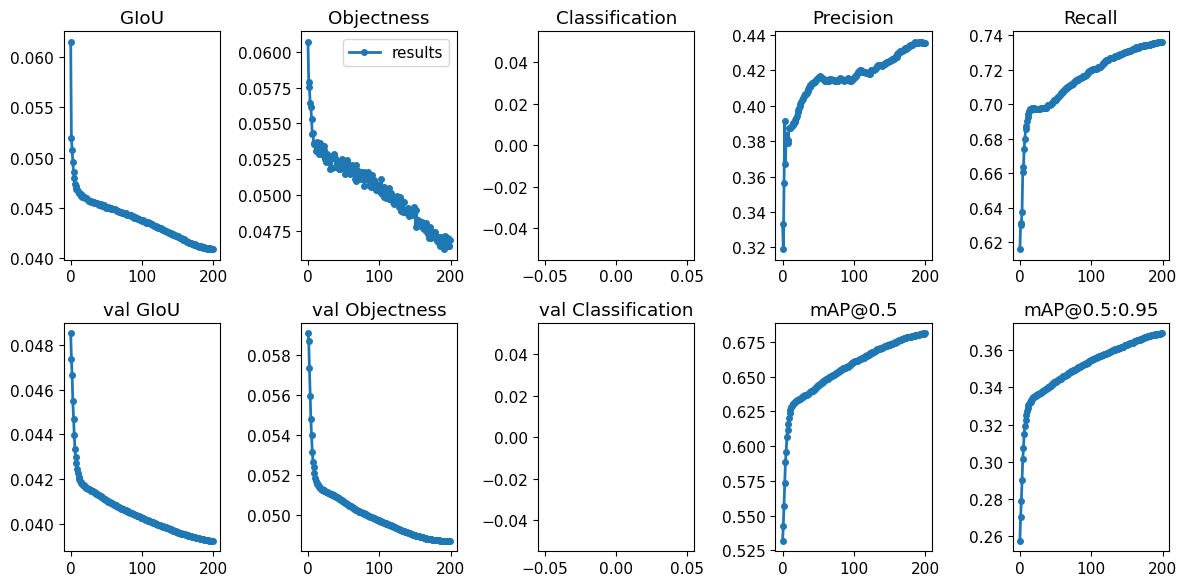

In [5]:
last = get_latest_run() if opt.resume == 'get_last' else opt.resume  # resume from most recent run
if last and not opt.weights:
    print(f'Resuming training from {last}')
opt.weights = last if opt.resume and not opt.weights else opt.weights
opt.cfg = check_file(opt.cfg)  # check file
opt.data = check_file(opt.data)  # check file
if opt.hyp:  # update hyps
    opt.hyp = check_file(opt.hyp)  # check file
    with open(opt.hyp) as f:
        hyp.update(yaml.load(f, Loader=yaml.FullLoader))  # update hyps
print(opt)
opt.img_size.extend([opt.img_size[-1]] * (2 - len(opt.img_size)))  # extend to 2 sizes (train, test)
device = torch_utils.select_device(opt.device, apex=mixed_precision, batch_size=opt.batch_size)
if device.type == 'cpu':
    mixed_precision = False

# Train
if not opt.evolve:
    tb_writer = SummaryWriter(log_dir=increment_dir('runs/exp', opt.name))
    print('Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/')
    try:
        train(hyp)
    except:
        traceback.print_exc()

# Evolve hyperparameters (optional)
else:
    tb_writer = None
    opt.notest, opt.nosave = True, True  # only test/save final epoch
    if opt.bucket:
        os.system('gsutil cp gs://%s/evolve.txt .' % opt.bucket)  # download evolve.txt if exists

    for _ in range(10):  # generations to evolve
        if os.path.exists('evolve.txt'):  # if evolve.txt exists: select best hyps and mutate
            # Select parent(s)
            parent = 'single'  # parent selection method: 'single' or 'weighted'
            x = np.loadtxt('evolve.txt', ndmin=2)
            n = min(5, len(x))  # number of previous results to consider
            x = x[np.argsort(-fitness(x))][:n]  # top n mutations
            w = fitness(x) - fitness(x).min()  # weights
            if parent == 'single' or len(x) == 1:
                # x = x[random.randint(0, n - 1)]  # random selection
                x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
            elif parent == 'weighted':
                x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

            # Mutate
            mp, s = 0.9, 0.2  # mutation probability, sigma
            npr = np.random
            npr.seed(int(time.time()))
            g = np.array([1, 1, 1, 1, 1, 1, 1, 0, .1, 1, 0, 1, 1, 1, 1, 1, 1, 1])  # gains
            ng = len(g)
            v = np.ones(ng)
            while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
            for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                hyp[k] = x[i + 7] * v[i]  # mutate

        # Clip to limits
        keys = ['lr0', 'iou_t', 'momentum', 'weight_decay', 'hsv_s', 'hsv_v', 'translate', 'scale', 'fl_gamma']
        limits = [(1e-5, 1e-2), (0.00, 0.70), (0.60, 0.98), (0, 0.001), (0, .9), (0, .9), (0, .9), (0, .9), (0, 3)]
        for k, v in zip(keys, limits):
            hyp[k] = np.clip(hyp[k], v[0], v[1])

        # Train mutation
        results = train(hyp.copy())

        # Write mutation results
        print_mutation(hyp, results, opt.bucket)

        # Plot results
        # plot_evolution_results(hyp)

In [6]:
%load_ext tensorboard
%tensorboard --logdir runs

### Visualize

GROUND TRUTH DATA:


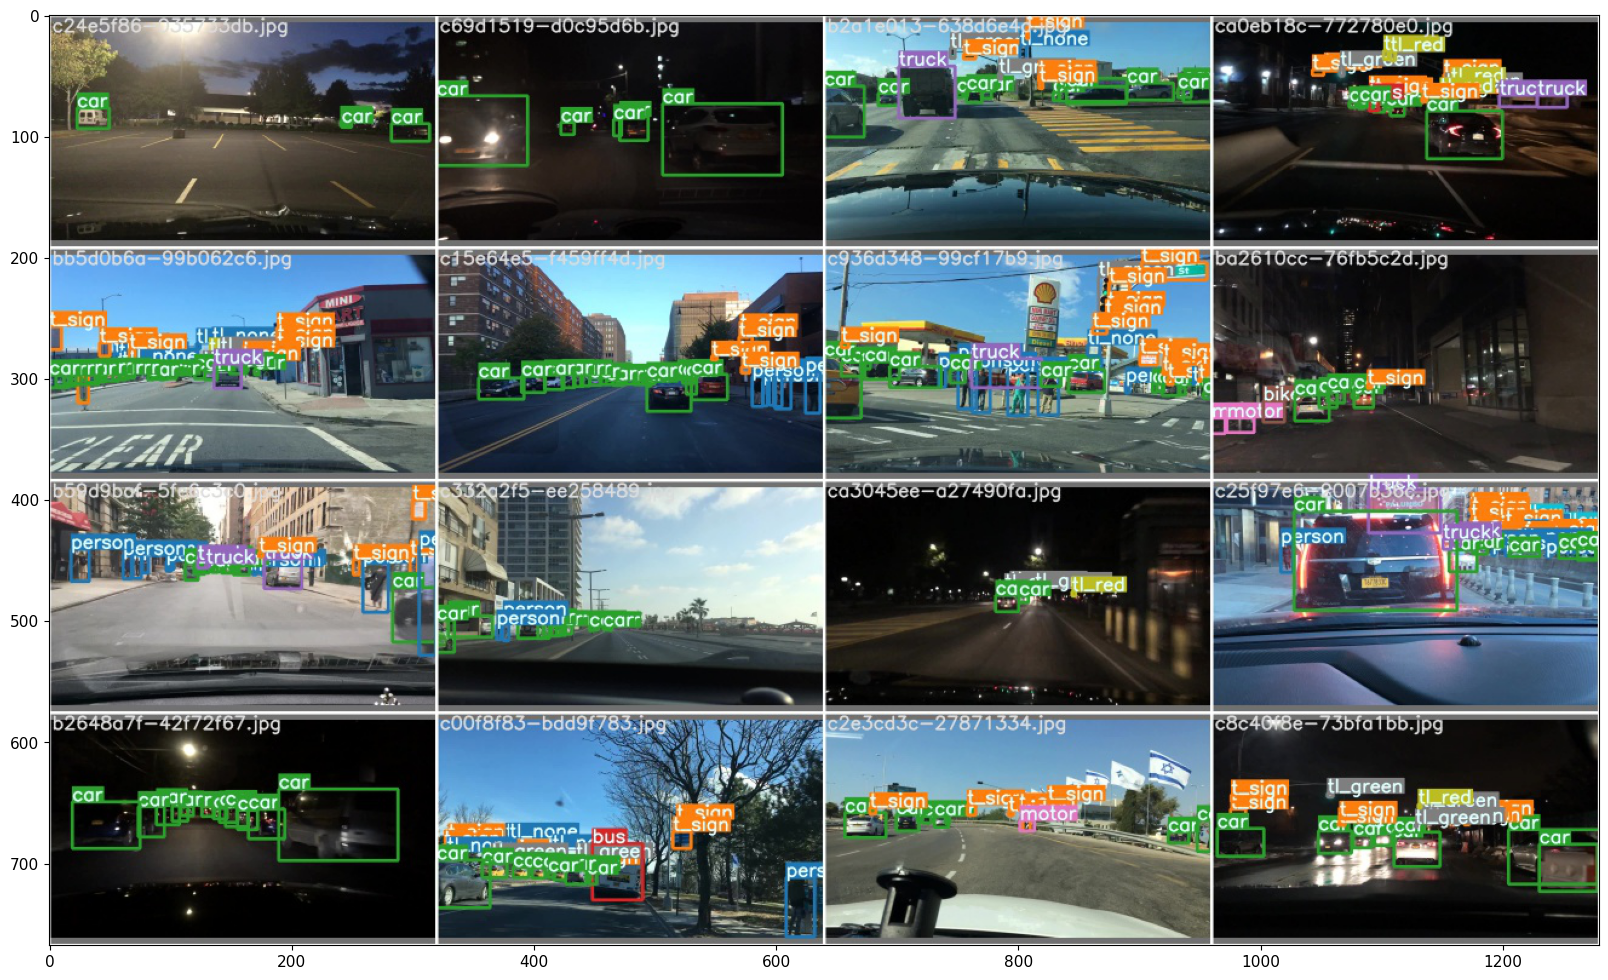

In [11]:
# first, display our ground truth data
print("GROUND TRUTH DATA:")
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread('runs/exp10_yolov5s_bdd_pre_2/test_batch0_gt.jpg'))

PREDICTED AUGMENTED DATA:


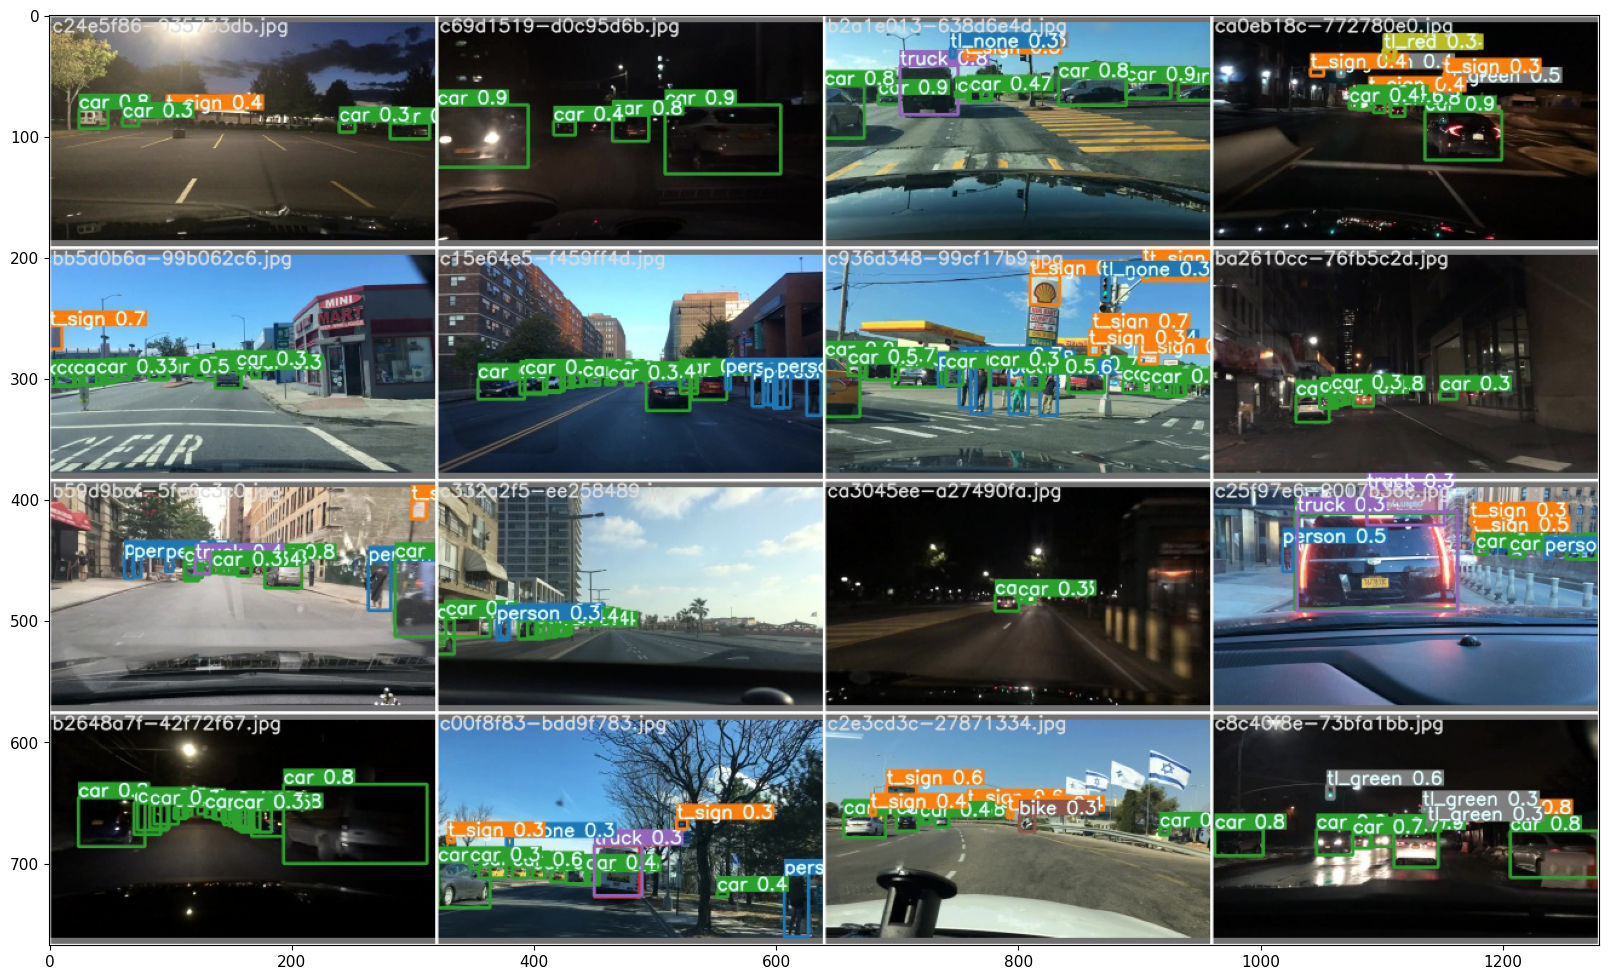

In [12]:
# print out an augmented training example
print("PREDICTED AUGMENTED DATA:")
plt.figure(figsize=(20, 20))
plt.imshow(plt.imread('runs/exp10_yolov5s_bdd_pre_2/test_batch0_pred.jpg'))